In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
vocab = sorted(list(set(''.join(words))))

In [4]:
# words Indexing
stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


# Build Dataset
- read the names from the names.txt
- find the vocab or character in the name.txt file
- Chose the block-size and make example dataset from the names
- X: input to the model
- Y: output by the model during traing

In [5]:
import random 
random.shuffle(words)

# Sudo Code
# define the contect length
# 1. read each word from words
# 2. read each letter from each w + '.'
# 3. for each letter extract the index of that letter and add it to the input context window and also extract the next letter in the word as output


Y = []
X = []
block_size = 3
for w in words:
    context = [0]*block_size
    for char in w + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

# Convert the input tokenized letters into torch tensor
Y = torch.tensor(Y)
X = torch.tensor(X)

# split the data into train val and test sets

x1 = int(0.8*len(words))
x2 = int(0.9*len(words))

dataset ={'train': [X[0:x1] , Y[0:x1]], 'val': [X[x1:x2], Y[x1:x2]], 'test': [X[x2:], Y[x2:]]}

dataset['train'][0].shape

Xtr,Ytr = dataset['train']
Xval, Yval = dataset['val']
Xtest, Ytest = dataset['test']

In [7]:
# Initializing the hacky wieghts

# vocab_size = 27
# n_embd = 10 
# n_hidden = 200 
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
# b1 = torch.randn(n_hidden,                        generator=g)
# W2 = torch.randn((n_hidden, vocab_size),          generator=g)
# b2 = torch.randn(vocab_size,                      generator=g) 


# parameters = [C, W1, W2, b2]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#   p.requires_grad = True

# Initializing the weight closer to zero inorder to control the output of post tahn activation in a control manner

# vocab_size = 27
# n_embd = 10 
# n_hidden = 200 
# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*0.01 
# b1 = torch.randn(n_hidden,                        generator=g)*0
# W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01
# b2 = torch.randn(vocab_size,                      generator=g)*0 


# parameters = [C, W1, W2, b2]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#   p.requires_grad = True


# initializing the wieghts with kamming he initialization method

# g = torch.Generator().manual_seed(2147483647) # for reproducibility
# C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)* ((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# b2 = torch.randn(vocab_size,                      generator=g) * 0


# parameters = [C, W1, W2, b2]
# print(sum(p.nelement() for p in parameters)) # number of parameters in total
# for p in parameters:
#   p.requires_grad = True

vocab_size = 27
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)* ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
bngain = torch.randn((1, n_hidden))
bnbiase = torch.randn((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbiase]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1  #+ b1 # hidden layer pre-activation
    # batch normalization linear

    bnmean_i = hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    hpreact = bngain*((hpreact - bnmean_i)/bnstd_i) + bnbiase
    with torch.no_grad():
        bnmean_running = bnmean_running*0.999 + bnmean_i*0.001
        bnstd_running = bnstd_running*0.999 + bnstd_i*0.001
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    #print(loss)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        #print(p.grad)
        p.data += -lr*p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2557
  10000/ 200000: 2.5213
  20000/ 200000: 1.7431
  30000/ 200000: 2.2119
  40000/ 200000: 2.2938
  50000/ 200000: 2.0330
  60000/ 200000: 2.0419
  70000/ 200000: 2.0355
  80000/ 200000: 2.2251
  90000/ 200000: 2.3524
 100000/ 200000: 2.1945
 110000/ 200000: 2.2150
 120000/ 200000: 2.0038
 130000/ 200000: 2.0084
 140000/ 200000: 1.9230


In [16]:
with torch.no_grad():
    emb = C[Xtr] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Ytr) # loss function
print(loss.item())

2.007805585861206


In [18]:
with torch.no_grad():
    emb = C[Xval] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yval) # loss function
print(loss.item())

2.3304409980773926


# Initialize the Model
- initialize the generator using torch.Generator().manual_seed(number)
- Initialize the the embedding matrix C
- 

In [ ]:
x = torch.randn(10000,10)
w = torch.randn(10,200)/ 10**0.5 # divide sqareroot 10
y = x @ w


a = torch.tanh(y)
# print(y.shape)
print(f'mean {x.mean()}, std: {x.std()}')
print(f'mean: {y.mean()}, str: {y.std()}')
plt.figure(figsize=(50,5))
plt.subplot(121)
plt.hist(a.view(-1).tolist(), 50, density=True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [17]:
# Forward Pass 
emb = parameters[0][X]   # Calculating The Embedding for each input
emb_cat = emb.view(-1,30)  # Reshapping the embedding matrix
preact  = emb_cat  @ parameters[1] + parameters[2]
a1 = torch.tanh(preact)
logits = a1 @ parameters[3] + parameters[4]
logits,a1, preact

In [30]:
for p in parameters:
    p.requires_grad = True

# A very in-depth explination of how the tanh function issues of vanishing the gradient flow due to that most of its post activation values are closer to 1 and -1. and during backpropagation (1 - t**2).out.grad, (t is closer to -1 or 1) vanishes the gradients flowing backward towards the paramters #

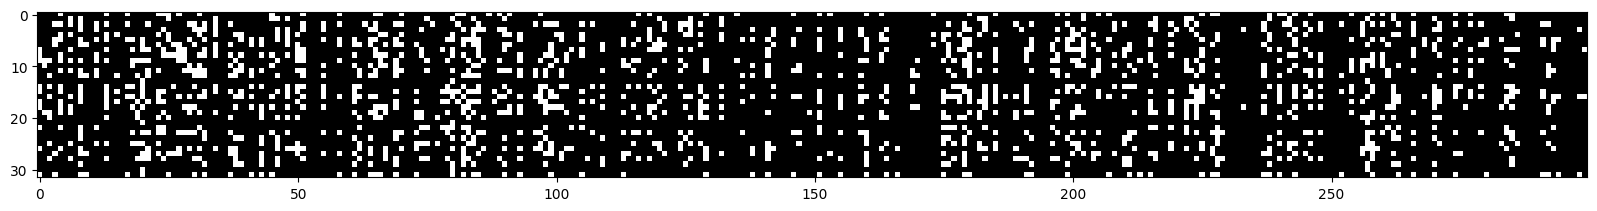

In [184]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

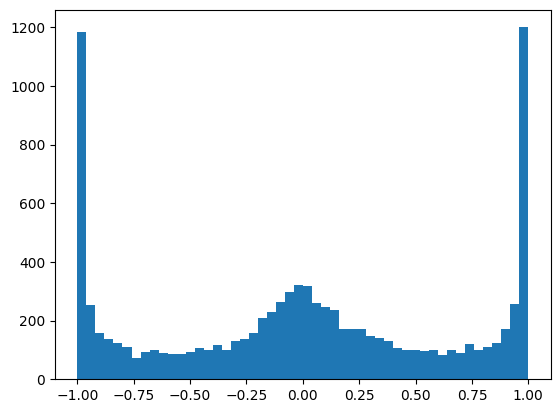

In [185]:
# logits[0]

plt.hist(h.view(-1).tolist(),50);


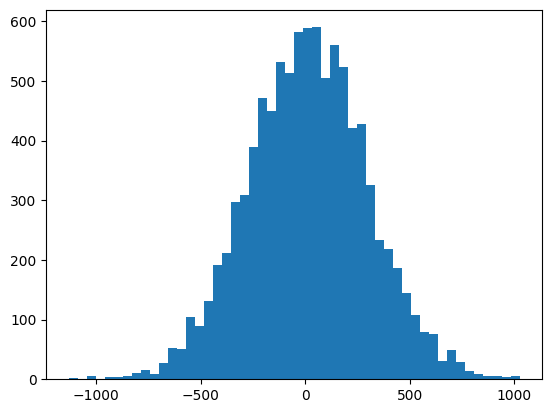

In [186]:
plt.hist(preact.view(-1).tolist(),50);

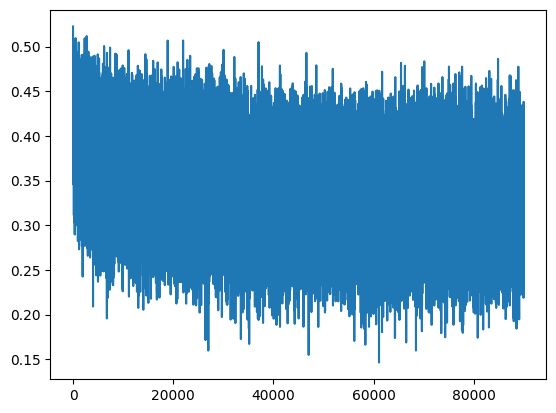

In [187]:
plt.plot(stepi, lossi)

In [191]:
# logits = torch.tensor([3.0,0.0,0.0,0.0])
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 0.2827, -0.0111, -0.4305,  0.1357]),
 tensor([0.3227, 0.2406, 0.1581, 0.2786]),
 tensor(1.8443))

In [192]:
# This code was effect for the emb_dim=2
# # plt.figure()
# plt.figure(figsize=(8,8))
# plt.scatter(parameters[0][:,0].data, parameters[0][:,1].data, s=200)
# for i in range(parameters[0].shape[0]):
#     plt.text(parameters[0][i,0].item(), parameters[0][i,1].item(), itos[i], ha='center', va='center', color='white')
# plt.grid('minor')

In [195]:
import torch
g = torch.Generator().manual_seed(2147483647)
stoi,itos, vocab_size = stoi_itos(words)
for i in range(10):
    ix = 0
    out = []
    block_size = 3
    context = [0] * block_size 
    while True:
        emb = parameters[0][torch.tensor([context])]
        preact = emb.view(-1,30) @ parameters[1] + parameters[2]
        hpreact = (parameters[-2] * (preact - preact.mean(0, keepdim=True)) / preact.std(0, keepdim=True)) +  parameters[-1]
        a1 = torch.tanh(hpreact)
        logits = a1 @ parameters[3] + parameters[4]
        print(logits)
        probs = F.softmax(logits ,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]], grad_fn=<AddBackward0>)


/tmp/ipykernel_3583/53290213.py:12: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  hpreact = (parameters[-2] * (preact - preact.mean(0, keepdim=True)) / preact.std(0, keepdim=True)) +  parameters[-1]


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [47]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

loss log
original:
train 2.2464447021484375  val 2.3154795169830322

fix softmax confidently wrong:
train 1.8785254955291748 val 2.301603078842163

fix tanh layer too saturated at init:
train 2.007805585861206 val 2.3304409980773926

use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

add batch norm layer
train 2.0668270587921143 val 2.104844808578491